In [47]:
%%capture
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from scipy.special import gammaln, betaln, binom
%matplotlib inline

In [48]:
np.random.dirichlet(np.ones(5))

array([ 0.22552962,  0.2815577 ,  0.13683469,  0.15159873,  0.20447925])

In [49]:
def empirical(alpha):
    p = np.random.dirichlet(alpha, size=100000)
    result = np.mean(np.log(p[:, 0] + p[:, 1]))
    return result

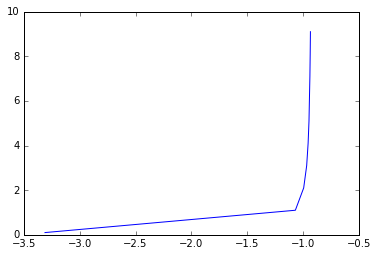

In [50]:
plt.plot([empirical(x*np.ones(5)) for x in np.arange(0.1, 10)], np.arange(0.1, 10))

In [51]:
def analytical(alpha, n_iter=1000):
    result = 0.
    alpha_x = alpha[0]
    alpha_y = alpha[1]
    alpha_z = np.sum(alpha[2:])
    for iter_i in range(1, n_iter+1):
        result += np.exp(betaln(alpha_x, alpha_y + alpha_z + iter_i) + \
                         betaln(alpha_y, alpha_z + iter_i) - \
                         log_mvbeta(alpha_x, alpha_y, alpha_z)) / iter_i
    return -result

In [52]:
analytical([1, 2, 3])

-0.78333331354180002

In [53]:
empirical([1, 2, 3])

-0.78520761498048119

In [54]:
generic_analytical_expectation(np.asarray([1, 2, 3]), 1, 0, 0, 0)

-2.2833333333333323

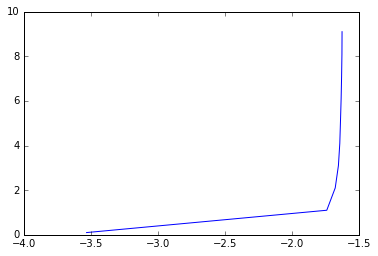

In [55]:
# plt.plot([analytical(x*np.asarray([1, 2, 3, 4, 5])) for x in np.arange(0.1, 10)], np.arange(0.1, 10))
plt.plot([empirical(x*np.asarray([1, 2, 3, 4, 5])) for x in np.arange(0.1, 10)], np.arange(0.1, 10))

In [56]:
# since beta(a, b) can be very small we use logarithms

def log_mbeta1(a, b):
    """ 
    ln(-beta'(a, b))
    """
    return betaln(a, b) + np.log(-digamma(a) + digamma(a + b))

def beta1(a, b):
    return -np.exp(log_mbeta1(a, b))

def log_beta2(a, b):
    """
    ln(beta"(a, b))
    """
    return betaln(a, b) + np.log((digamma(a) - digamma(a + b))**2 + (polygamma(1, a) - polygamma(1, a + b)))

def beta2(a, b):
    return np.exp(log_beta2(a, b))

In [57]:
def empirical(alpha):
    p = np.random.dirichlet(alpha, size=100000)
    result = np.mean(np.log(p[:, 1]))
    return result

In [58]:
empirical(np.asarray([1, 4, 3]))

-0.75874277010383584

In [59]:
from scipy.special import digamma, gamma, gammaln, beta, betaln, polygamma
from scipy.misc import derivative

In [60]:
def log_mvbeta(*alphas):
    return np.sum([gammaln(alpha) for alpha in alphas]) - gammaln(np.sum(alphas))

In [61]:
def log_betaderiv_xy(x, y):
    result1 = betaln(x, y)
    result1 += np.log(digamma(x + y) - digamma(x))
    result1 += np.log(digamma(x + y) - digamma(y))
    result1 = np.exp(result1)
    
    result2 = betaln(x, y)
    result2 += np.log(polygamma(1, x + y))
    result2 = -np.exp(result2)
    
    return result1 + result2

In [62]:
def analytical(alpha, n_iter=1000):
    alpha_x = alpha[0]
    alpha_y = alpha[1]
    alpha_z = np.sum(alpha[2:])
    
    result1 = 0.
    result1 += log_mbeta1(alpha_y, alpha_z)
    result1 += betaln(alpha_x, alpha_y + alpha_z)
    result1 -= log_mvbeta(alpha_x, alpha_y, alpha_z)
    result1 = -np.exp(result1)
    print result1
    
    result2 = 0.
    result2 += betaln(alpha_y, alpha_z)
    result2 += log_mbeta1(alpha_y + alpha_z, alpha_x)
    result2 -= log_mvbeta(alpha_x, alpha_y, alpha_z)
    result2 = -np.exp(result2)
    print result2
        
    return result1 + result2

In [63]:
def log_beta_deriv(x, y, nx, ny):
    if nx < ny: 
        return log_beta_deriv(y, x, ny, nx)
    if nx == 0:
        return betaln(x, y), +1
    elif nx == 1 and ny == 0:
        return np.log(digamma(x + y) - digamma(x)) + betaln(x, y), -1
    elif nx == 2 and ny == 0:
        return np.log((digamma(x + y) - digamma(x)) ** 2 + (polygamma(1, x) - polygamma(1, x + y))) + \
            betaln(x, y), +1
    elif nx == 1 and ny == 1:
        return np.log((digamma(x + y) - digamma(x))*(digamma(x + y) - digamma(y)) - polygamma(1, x + y)) + \
            betaln(x, y), +1
    else:
        raise Exception("not implemented for nx={}, ny={}".format(nx, ny))

In [64]:
log_beta_deriv(4, 3, 0, 2), log_beta2(3, 4)

((-3.9599107990785671, 1), -3.9599107990785671)

In [142]:
def beta_analytical_expectation1(alpha_x, alpha_y, m_x, k_x, m_y, k_y):
    val, sign = log_beta_deriv(alpha_x + k_x, alpha_y + k_y, m_x, m_y)
    return sign * np.exp(val - betaln(alpha_x, alpha_y))

In [143]:
def generic_analytical_expectation1(alpha_x, alpha_y, alpha_z, m_x, k_x, m_y, k_y, n_z=0):
    #print alpha_x, alpha_y, alpha_z
    
    if alpha_z < 0.5:
        return beta_analytical_expectation1(alpha_x, alpha_y, m_x, k_x, m_y, k_y)
    
    result = 0.
    for i in range(m_y + 1):
        current = 0.
        sign = +1
        
        d1_log, d1_sign = log_beta_deriv(alpha_x + k_x, 
                                         alpha_y + alpha_z + n_z + k_y, 
                                         m_x, i)
        
        current += d1_log
        sign *= d1_sign
        
        d2_log, d2_sign = log_beta_deriv(alpha_y + k_y, alpha_z + n_z,
                                         m_y - i, 0)

        current += d2_log
        sign *= d2_sign
        
    
        current -= log_mvbeta(alpha_x, alpha_y, alpha_z)

        result += sign * np.exp(current) * binom(m_y, i)
    return result

def generic_analytical_expectation(alpha, m_x, k_x, m_y, k_y, x=0, y=1):
    alpha_x = alpha[x]
    alpha_y = alpha[y]
    alpha_z = np.sum(alpha) - alpha_x - alpha_y
    
    return generic_analytical_expectation1(alpha_x, alpha_y, alpha_z, m_x, k_x, m_y, k_y)

In [66]:
def analytical_covariance(alpha, x, y):
    return generic_analytical_expectation(alpha, 1, 1, 1, 1, x=x, y=y) - \
        (generic_analytical_expectation(alpha, 1, 1, 0, 0, x=x, y=y) * \
         generic_analytical_expectation(alpha, 0, 0, 1, 1, x=x, y=y))

In [67]:
def analytical_variance(alpha, x):
    y = (x + 1) % len(alpha)
    return generic_analytical_expectation(alpha, 2, 2, 0, 0, x=x, y=y) - \
        (generic_analytical_expectation(alpha, 1, 1, 0, 0, x=x, y=y)**2)

In [68]:
generic_analytical_expectation(np.asarray([1, 7, 3]), 1, 1, 1, 1)

0.052681553314663856

In [69]:
def empirical(alpha):
    p = np.random.dirichlet(alpha, size=1000000)
    result = np.mean(np.log(p[:, 0]) * p[:, 0] * \
                     np.log(p[:, 1]) * p[:, 1])
                    #p[:, 0] * p[:, 1])
    return result
empirical(np.asarray([1, 7, 3]))

0.052697450911594744

In [70]:
def empirical_variance(alpha):
    p = np.random.dirichlet(alpha, size=1000000)
    result = np.var(p[:, 0] * np.log(p[:, 0]), ddof=1)
    return result

In [71]:
empirical_variance([1, 2, 3, 4]), analytical_variance([1, 2, 3, 4], 0)

(0.010401436669317848, 0.010391893614515119)

In [72]:
analytical_covariance([1, 2, 3, 4], 0, 1)

-0.00089116171960386403

In [73]:
def empirical_entropy_variance(alpha):
    p = np.random.dirichlet(alpha, size=1000000)
    result = np.var(-np.sum(p * np.log(p), axis=1), ddof=1)
    return result

In [77]:
empirical_entropy_variance([1, 2, 3])

0.027551015042473037

In [78]:
alpha = np.random.dirichlet(np.ones(10)) * 100
empirical_entropy_variance(alpha)

0.0033055616222028325

In [79]:
def entropy_variance_analytical(alpha):
    result = 0.
    for i, alpha_i in enumerate(alpha):
        result += analytical_variance(alpha, i)
    for i, alpha_i in enumerate(alpha):
        for j, alpha_j in enumerate(alpha):
            if i == j: continue
            result += analytical_covariance(alpha, i, j)
    return result

In [80]:
entropy_variance_analytical([1, 2, 3])

0.027574218952516792

In [81]:
entropy_variance_analytical(alpha)

0.0033030059629875468

In [82]:
def generic_analytical_expectation_sum1(alpha_x, alpha_y, alpha_z, m_x, k_x, m_y, k_y, x=0, y=1, tol=1e-6):
    result = 0.
    prev = np.inf
    iter_i = 1
    while np.abs(prev - result) > tol:
        prev = result
        result += generic_analytical_expectation1(alpha_x, alpha_y, alpha_z,
                                                  m_x=m_x, k_x=k_x, m_y=m_y, k_y=k_y, n_z=iter_i) / iter_i
        iter_i += 1
        
    return -result

def generic_analytical_expectation_sum(alpha, m_x, k_x, m_y, k_y, x=0, y=1, tol=1e-6):    
    alpha = np.asarray(alpha, dtype=float)
    alpha_x = alpha[x]
    alpha_y = alpha[y]
    alpha_z = np.sum(alpha) - alpha_x - alpha_y
    
    return generic_analytical_expectation_sum1(alpha_x, alpha_y, alpha_z, 
                                                   m_x, k_x, m_y, k_y, x=x, y=x, tol=tol)

In [83]:
def empirical(alpha):
    p = np.random.dirichlet(alpha, size=100000)
    result = np.mean(np.log(p[:, 0] + p[:, 1]))
    return result

In [84]:
generic_analytical_expectation_sum([1, 2, 30], 0, 0, 0, 0, tol=1e-5)

-2.5577252364163967

In [85]:
generic_analytical_expectation([3, 1, 29], 1, 0, 0, 0)

-2.5584951954364783

In [86]:
empirical([2, 3, 4])

-0.63605696252091559

In [87]:
def empirical(alpha):
    p = np.random.dirichlet(alpha, size=100000)
    result = np.mean(np.log(p[:, 0] + p[:, 1]) * np.log(p[:, 0]) * p[:, 0] * p[:, 0])
    return result

In [88]:
generic_analytical_expectation_sum([2, 3, 4], 1, 2, 0, 0)

0.038874427778142755

In [89]:
empirical([2, 3, 4])

0.038935868900466755

In [359]:
def empirical(alpha):
    p = np.random.dirichlet(alpha, size=100000)
    result = np.mean(np.log(p[:, 0] + p[:, 1]) * np.log(p[:, 0]) * p[:, 0] * p[:, 1])
    return result

In [360]:
generic_analytical_expectation_sum([2, 3, 4], 1, 1, 0, 1)

0.049517801054112055

In [361]:
empirical([2, 3, 4])

0.049528080908722648

In [391]:
def difference_variance(n_xy):
    n_xy = np.asarray(n_xy)
    n_x = np.sum(n_xy, axis=0)
    n_xy_flat = n_xy.flatten()
    n = np.sum(n_xy)
    
    result = entropy_variance_analytical(n_xy_flat) + entropy_variance_analytical(n_x)
    
    print result
    
    for a in range(n_xy.shape[1]):
        for b in range(n_xy.shape[0]):
            for c in range(n_xy.shape[1]):
                if a == c:
                    alpha_x = n_xy[b, a]
                    alpha_y = n_x[a] - alpha_x

                    alpha_z = n - alpha_x - alpha_y
                    part1 = generic_analytical_expectation_sum1(alpha_x, alpha_y, alpha_z, 
                                                                1, 2, 0, 0, tol=1e-10)
                    part2 = generic_analytical_expectation_sum1(alpha_x, alpha_y, alpha_z,
                                                            1, 1, 0, 1, tol=1e-10)
                    current = part1 + part2

                    current -= generic_analytical_expectation1(alpha_x, alpha_y, alpha_z, 
                                                               1, 1, 0, 0) * \
                                generic_analytical_expectation1(alpha_x + alpha_y, 1, alpha_z - 1, 
                                                                1, 1, 0, 0)

                    result += -2 * current
                else:
                    alpha_x = n_xy[b, c]
                    alpha_y = n_x[a]
                    alpha_z = n - alpha_x - alpha_y

                    current = generic_analytical_expectation1(alpha_x, alpha_y, alpha_z, 1, 1, 1, 1)

                    current -= generic_analytical_expectation1(alpha_x, alpha_y, alpha_z, 1, 1, 0, 0) * \
                                generic_analytical_expectation1(alpha_x, alpha_y, alpha_z, 0, 0, 1, 1)

                    result += -2 * current
    
    return result

In [410]:
def empirical(n_xy):
    n_xy = np.asarray(n_xy)
    size = 100000
    p = np.random.dirichlet(n_xy.flatten(), size=size)
    p = p.reshape((-1,) + n_xy.shape)
    
    p_x = p.sum(axis=1)
    return np.var(np.sum(np.sum(p * np.log(p), axis=2), axis=1) - np.sum(p_x * np.log(p_x), axis=1))

In [411]:
arr = np.asarray([[2, 2, 10, 15], [1, 20, 3, 15], [1, 2, 10, 15]])
difference_variance(arr), empirical(arr)

0.00719835126631


(0.0027824781691178965, 0.0027681191793719178)

In [395]:
empirical([[2, 2, 1], [2, 2, 1], [1, 1, 1]])

[[ 0.09551558  0.10772837  0.01329695]
 [ 0.34510606  0.17774463  0.11102416]
 [ 0.14523922  0.00213923  0.00220579]]
(100000, 3, 3)
(3, 3)


0.011258520551995449

In [283]:
def empirical_term(n_xy, a, b, c):
    n_xy = np.asarray(n_xy)
    size = 100000
    p = np.random.dirichlet(n_xy.flatten(), size=size)
    p = p.reshape((-1,) + n_xy.shape)
    
    p_x = p.sum(axis=1)
    return -np.cov(p[:, b, c] * np.log(p[:, b, c]), p_x[:, a] * np.log(p_x[:, a]))

In [396]:
def analytical_term(n_xy, a, b, c):
    n_xy = np.asarray(n_xy)
    n_x = np.sum(n_xy, axis=0)
    n_xy_flat = n_xy.flatten()
    n = np.sum(n_xy)
    
    if a == c:
        alpha_x = n_xy[b, a]
        alpha_y = n_x[a] - alpha_x


        alpha_z = n - alpha_x - alpha_y
        part1 = generic_analytical_expectation_sum1(alpha_x, alpha_y, alpha_z, 
                                                    1, 2, 0, 0, tol=1e-20)
        part2 = generic_analytical_expectation_sum1(alpha_x, alpha_y, alpha_z,
                                                1, 1, 0, 1, tol=1e-20)
        current = part1 + part2
        
        current -= generic_analytical_expectation1(alpha_x, alpha_y, alpha_z, 
                                                   1, 1, 0, 0) * \
                    generic_analytical_expectation1(alpha_x + alpha_y, 1, alpha_z - 1, 
                                                    1, 1, 0, 0)
        print current

        return -current
    else:
        print 'tick'
        alpha_x = n_xy[b, c]
        alpha_y = n_x[a]
        alpha_z = n - alpha_x - alpha_y
        
        print alpha_x, alpha_y, alpha_z

        current = generic_analytical_expectation1(alpha_x, alpha_y, alpha_z, 1, 1, 1, 1)

        current -= generic_analytical_expectation1(alpha_x, alpha_y, alpha_z, 1, 1, 0, 0) * \
                    generic_analytical_expectation1(alpha_x, alpha_y, alpha_z, 0, 0, 1, 1)

        return -current

In [397]:
def empirical_term(n_xy, a, b, c):
    n_xy = np.asarray(n_xy)
    size = 100000
    p = np.random.dirichlet(n_xy.flatten(), size=size)
    p = p.reshape((-1,) + n_xy.shape)
    
    p_x = p.sum(axis=1)
    print -np.cov(p[:, b, c] * np.log(p[:, b, c]), p_x[:, a] * np.log(p_x[:, a]))
    print np.mean(p[:, b, c] * np.log(p[:, b, c])) * np.mean(p_x[:, a] * np.log(p_x[:, a]))
    print np.mean(p[:, b, c] * np.log(p[:, b, c]) * p_x[:, a] * np.log(p_x[:, a]))

In [398]:
empirical_term([[2, 2, 1], [2, 5, 1], [1, 1, 1]], 0, 2, 0)

[[-0.00796977 -0.00070632]
 [-0.00070632 -0.00102653]]
0.0510418546361
0.0517481653667


In [399]:
analytical_term([[2, 2, 1], [2, 5, 1], [1, 1, 1]], 0, 2, 0)

0.000712868988135


-0.00071286898813484323